# A simple neural network model is applied to the MNIST datasets by PyTorch

## 1. Load MNIST dataset
Dataset of MNIST images is loaded: two datasets for training and test ($N_{train}=60,000, N_{test}=10,000$).

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.datasets import fetch_openml
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import datasets, transforms

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] → [0, 1]
    #transforms.Normalize((0.1307,), (0.3081,))  
])

In [31]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [47]:
# batch size: 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

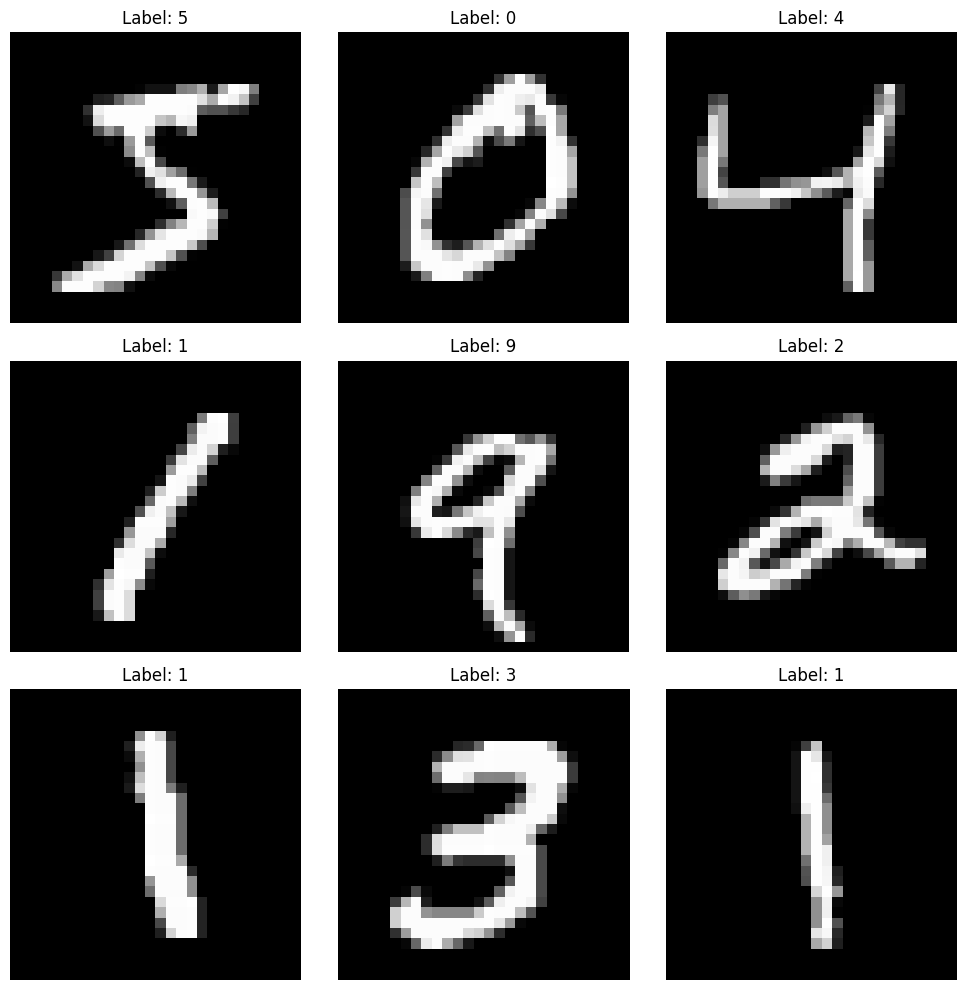

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        image, label = train_dataset[idx]
        image = image.squeeze(0) 
        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].set_title(f"Label: {label}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## 2. A neural network model with two hidden layers 
As the simple example, a neural network model with two hidden layers (1st layer: 128 units, 2nd layer: 64 units) is defined.
ReLU activation functions are used and Adam optimiser is emplyed.

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # input -> hidden 
        self.fc2 = nn.Linear(128, 64)     # hidden-> hidden
        self.fc3 = nn.Linear(64, 10)      # hidden -> output

    def forward(self, x):
        x = x.view(-1, 28*28)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [103]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [104]:
train_losses = []
test_losses = []
test_accuracies =[]

In [105]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    batch_count = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        #print(f'Loss: {loss.item():.4f}')

        total_loss += loss.item()
        batch_count += 1
    
    avg_loss = total_loss / batch_count
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}: Average Training Loss = {avg_loss:.4f}")

In [100]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Train the defined neural network model

In [107]:
for epoch in range(1, 100):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader)

Epoch 1: Average Training Loss = 0.8965

Test set: Average loss: 0.3755, Accuracy: 9008/10000 (90.08%)

Epoch 2: Average Training Loss = 0.3370

Test set: Average loss: 0.2932, Accuracy: 9188/10000 (91.88%)

Epoch 3: Average Training Loss = 0.2838

Test set: Average loss: 0.2584, Accuracy: 9262/10000 (92.62%)

Epoch 4: Average Training Loss = 0.2534

Test set: Average loss: 0.2347, Accuracy: 9319/10000 (93.19%)

Epoch 5: Average Training Loss = 0.2297

Test set: Average loss: 0.2163, Accuracy: 9365/10000 (93.65%)

Epoch 6: Average Training Loss = 0.2102

Test set: Average loss: 0.1992, Accuracy: 9416/10000 (94.16%)

Epoch 7: Average Training Loss = 0.1929

Test set: Average loss: 0.1834, Accuracy: 9443/10000 (94.43%)

Epoch 8: Average Training Loss = 0.1772

Test set: Average loss: 0.1712, Accuracy: 9482/10000 (94.82%)

Epoch 9: Average Training Loss = 0.1634

Test set: Average loss: 0.1615, Accuracy: 9492/10000 (94.92%)

Epoch 10: Average Training Loss = 0.1510

Test set: Average loss

## 3. Results
Training and Test losses are displayed. Epochs=100 seems too much and it is overfitting.
Epochs~40 are appropriate. The accuracy reaches around 98% after the optimisation.

/var/folders/lr/pxblv13942x0dw1dftv9phx40000gn/T/ipykernel_21770/1018493685.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,0.4)


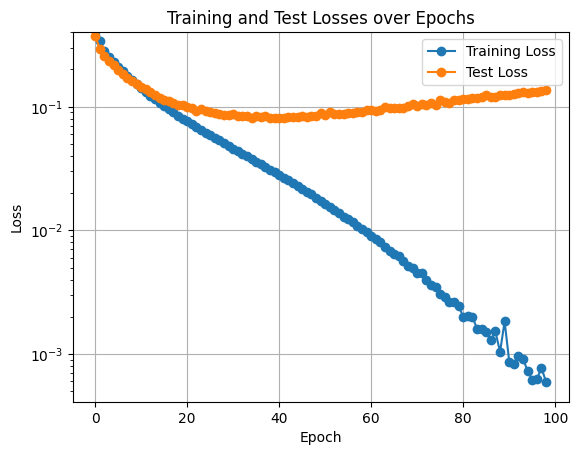

In [116]:
import matplotlib.pyplot as plt

plt.plot(train_losses, marker='o', label='Training Loss')
plt.plot(test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses over Epochs')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.ylim(0,0.4)
plt.show()

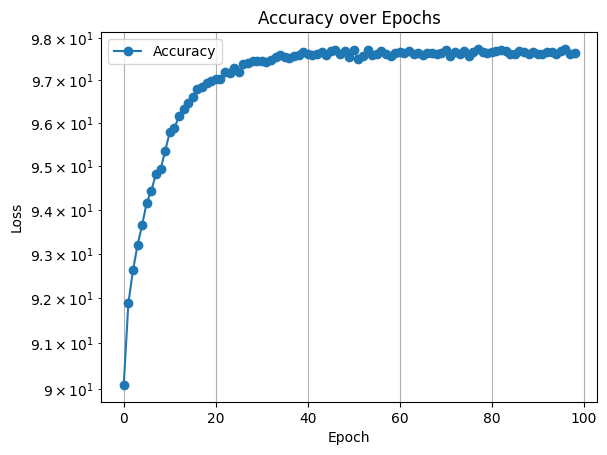

In [120]:
plt.plot(test_accuracies, marker='o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy over Epochs')
plt.legend()
plt.yscale('log')
plt.grid(True)
#plt.ylim(0,0.4)
plt.show()

The confusion matrix is shown as well as other methods.

In [130]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [131]:
def plot_confusion_matrix(model, device, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

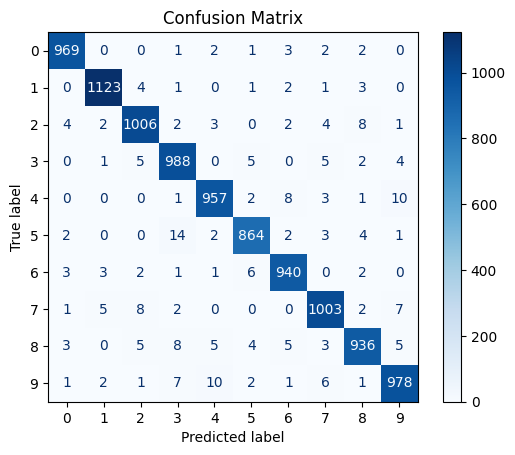

In [132]:
plot_confusion_matrix(model, device, test_loader)